<a href="https://colab.research.google.com/github/PGLavergne/NYTCrosswordPredicter/blob/main/Project_Part_III.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

url = 'https://raw.githubusercontent.com/PGLavergne/NYTCrosswordPredicter/main/nytcrosswords.csv'
dataSet = pd.read_csv(url, encoding='latin-1')
dataSet_partial = pd.read_csv(url, encoding='latin-1', nrows=3000)
dataSet

,Date,Word,Clue
0,10/31/2021,PAT,"Action done while saying ""Good dog"""
1,10/31/2021,RASCALS,Mischief-makers
2,10/31/2021,PEN,It might click for a writer
3,10/31/2021,SEP,Fall mo.
4,10/31/2021,ECO,Kind to Mother Nature
...,...,...,...
781568,11/21/1993,NAT,Actor Pendleton
781569,11/21/1993,SHRED,Bit
781570,11/21/1993,NEA,Teachers' org.
781571,11/21/1993,BEG,Petition


The code below will initialize the GPT2 model and tokenizer from Hugging Face. It will train the model and and allow the user to input a clue and generate a predicted word.

/usr/local/lib/python3.10/dist-packages/transformers/data/datasets/language_modeling.py:53: FutureWarning: This dataset will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/language-modeling/run_mlm.py
  warnings.warn(


Epoch 1/25:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 1/25 - Training Loss: 4.095969550749835


Validation - Epoch 1/25:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 1/25 - Validation Loss: 3.2538571811857677


Epoch 2/25:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 2/25 - Training Loss: 2.8590017487021053


Validation - Epoch 2/25:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 2/25 - Validation Loss: 2.803913048335484


Epoch 3/25:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 3/25 - Training Loss: 2.4583452589371624


Validation - Epoch 3/25:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 3/25 - Validation Loss: 2.669607855024792


Epoch 4/25:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 4/25 - Training Loss: 2.239305720609777


Validation - Epoch 4/25:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 4/25 - Validation Loss: 2.642304295585269


Epoch 5/25:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 5/25 - Training Loss: 2.0625552149379955


Validation - Epoch 5/25:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 5/25 - Validation Loss: 2.6783557619367326


Epoch 6/25:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 6/25 - Training Loss: 1.9170122286852669


Validation - Epoch 6/25:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 6/25 - Validation Loss: 2.711043891452608


Epoch 7/25:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 7/25 - Training Loss: 1.7585684692158419


Validation - Epoch 7/25:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 7/25 - Validation Loss: 2.7891176541646323


Epoch 8/25:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 8/25 - Training Loss: 1.5886268896215103


Validation - Epoch 8/25:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 8/25 - Validation Loss: 2.907245227268764


Epoch 9/25:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 9/25 - Training Loss: 1.4035879864412195


Validation - Epoch 9/25:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 9/25 - Validation Loss: 3.1312502338772727


Epoch 10/25:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 10/25 - Training Loss: 1.2190794524024515


Validation - Epoch 10/25:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 10/25 - Validation Loss: 3.335698298045567


Epoch 11/25:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 11/25 - Training Loss: 1.0336380741175484


Validation - Epoch 11/25:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 11/25 - Validation Loss: 3.501771325156802


Epoch 12/25:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 12/25 - Training Loss: 0.880115130368401


Validation - Epoch 12/25:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 12/25 - Validation Loss: 3.731542939231509


Epoch 13/25:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 13/25 - Training Loss: 0.7487606160780963


Validation - Epoch 13/25:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 13/25 - Validation Loss: 3.8289515404474166


Epoch 14/25:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 14/25 - Training Loss: 0.6266910538953894


Validation - Epoch 14/25:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 14/25 - Validation Loss: 3.927506900969006


Epoch 15/25:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 15/25 - Training Loss: 0.5286631268613479


Validation - Epoch 15/25:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 15/25 - Validation Loss: 4.134141604105632


Epoch 16/25:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 16/25 - Training Loss: 0.4454728207167457


Validation - Epoch 16/25:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 16/25 - Validation Loss: 4.230928069069272


Epoch 17/25:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 17/25 - Training Loss: 0.37321556841625886


Validation - Epoch 17/25:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 17/25 - Validation Loss: 4.326398849487305


Epoch 18/25:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 18/25 - Training Loss: 0.31927639771910277


Validation - Epoch 18/25:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 18/25 - Validation Loss: 4.343471856344314


Epoch 19/25:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 19/25 - Training Loss: 0.2705070569234736


Validation - Epoch 19/25:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 19/25 - Validation Loss: 4.433052607945034


Epoch 20/25:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 20/25 - Training Loss: 0.22843550320933848


Validation - Epoch 20/25:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 20/25 - Validation Loss: 4.428430648077102


Epoch 21/25:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 21/25 - Training Loss: 0.17649575629655054


Validation - Epoch 21/25:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 21/25 - Validation Loss: 4.511467365991502


Epoch 22/25:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 22/25 - Training Loss: 0.14052447720485575


Validation - Epoch 22/25:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 22/25 - Validation Loss: 4.564590227036249


Epoch 23/25:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 23/25 - Training Loss: 0.10024174565778059


Validation - Epoch 23/25:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 23/25 - Validation Loss: 4.6672514733814054


Epoch 24/25:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 24/25 - Training Loss: 0.07012344085994889


Validation - Epoch 24/25:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 24/25 - Validation Loss: 4.689270859672909


Epoch 25/25:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 25/25 - Training Loss: 0.04931482672691345


Validation - Epoch 25/25:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 25/25 - Validation Loss: 4.703536147163028


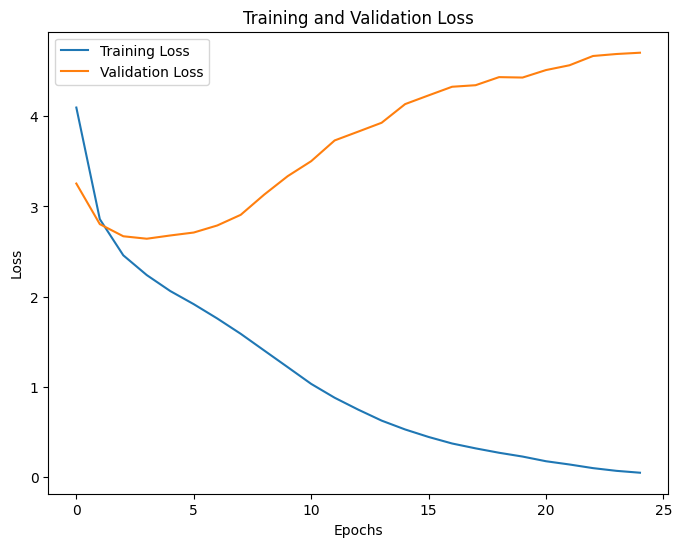

In [ ]:
from transformers import GPT2LMHeadModel, GPT2Tokenizer, TextDataset, DataCollatorForLanguageModeling
from torch.utils.data import DataLoader, random_split
from tqdm.auto import tqdm
import torch
import matplotlib.pyplot as plt
import pandas as pd

# Load your dataset
url = 'https://raw.githubusercontent.com/PGLavergne/NYTCrosswordPredicter/main/nytcrosswords.csv'
dataSet = pd.read_csv(url, encoding='latin-1')
dataSet_partial = pd.read_csv(url, encoding='latin-1', nrows=3000)

# Initialize tokenizer and model
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
tokenizer.pad_token = tokenizer.eos_token
model = GPT2LMHeadModel.from_pretrained('gpt2')

# Save a subset of the dataset to a text file
dataSet_partial.to_csv('dataSet_partial.txt', sep='\t', index=False)
file_path = 'dataSet_partial.txt'
dataset = TextDataset(tokenizer=tokenizer, file_path=file_path, block_size=128)

data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)

train_batch_size = 20
val_batch_size = 4
epochs = 25
learning_rate = 5e-5

# Split dataset into train and validation sets
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create loaders for train and validation sets
train_loader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=val_batch_size)

optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
train_losses = []
val_losses = []

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.train()

for epoch in range(epochs):
    total_loss = 0
    for batch in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{epochs}"):
        batch = batch.to(device)
        outputs = model(input_ids=batch, labels=batch)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        total_loss += loss.item()

    train_loss = total_loss / len(train_loader)
    train_losses.append(train_loss)
    print(f"Epoch {epoch + 1}/{epochs} - Training Loss: {train_loss}")

    # Validation loop
    model.eval()
    val_epoch_losses = []
    with torch.no_grad():
        for val_batch in tqdm(val_loader, desc=f"Validation - Epoch {epoch + 1}/{epochs}"):
            val_batch = val_batch.to(device)
            val_outputs = model(input_ids=val_batch, labels=val_batch)
            val_loss = val_outputs.loss
            val_epoch_losses.append(val_loss.item())

    avg_val_loss = sum(val_epoch_losses) / len(val_epoch_losses)
    val_losses.append(avg_val_loss)
    print(f"Epoch {epoch + 1}/{epochs} - Validation Loss: {avg_val_loss}")

# Plotting training and validation losses
plt.figure(figsize=(8, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/data/datasets/language_modeling.py:53: FutureWarning: This dataset will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/language-modeling/run_mlm.py
  warnings.warn(


Epoch 1/5:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 1/5 - Training Loss: 4.12387874547173


Validation - Epoch 1/5:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 1/5 - Validation Loss: 3.22425187201727


Epoch 2/5:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 2/5 - Training Loss: 2.8905802053563736


Validation - Epoch 2/5:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 2/5 - Validation Loss: 2.7713730675833568


Epoch 3/5:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 3/5 - Training Loss: 2.4643908248228183


Validation - Epoch 3/5:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 3/5 - Validation Loss: 2.6438350791022893


Epoch 4/5:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 4/5 - Training Loss: 2.238476402619306


Validation - Epoch 4/5:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 4/5 - Validation Loss: 2.6140903064182828


Epoch 5/5:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 5/5 - Training Loss: 2.0695171776939842


Validation - Epoch 5/5:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 5/5 - Validation Loss: 2.6461817650567916


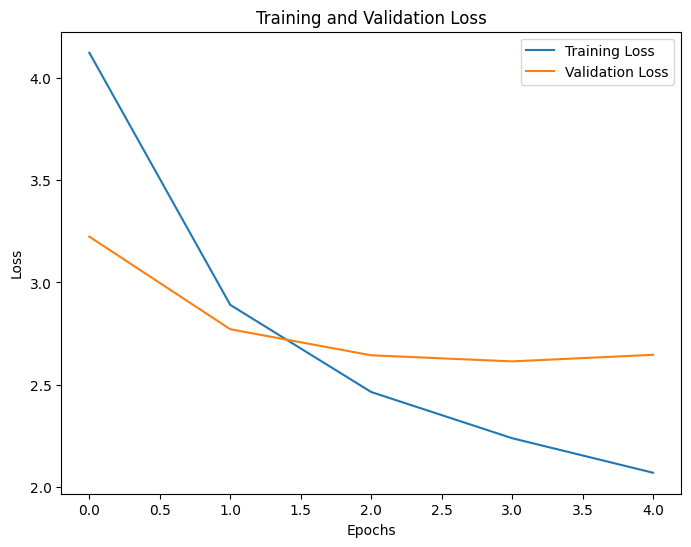

In [1]:
from transformers import GPT2LMHeadModel, GPT2Tokenizer, TextDataset, DataCollatorForLanguageModeling
from torch.utils.data import DataLoader, random_split
from tqdm.auto import tqdm
import torch
import matplotlib.pyplot as plt
import pandas as pd

# Load your dataset
url = 'https://raw.githubusercontent.com/PGLavergne/NYTCrosswordPredicter/main/nytcrosswords.csv'
dataSet = pd.read_csv(url, encoding='latin-1')
dataSet_partial = pd.read_csv(url, encoding='latin-1', nrows=3000)

# Initialize tokenizer and model
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
tokenizer.pad_token = tokenizer.eos_token
model = GPT2LMHeadModel.from_pretrained('gpt2')

# Save a subset of the dataset to a text file
dataSet_partial.to_csv('dataSet_partial.txt', sep='\t', index=False)
file_path = 'dataSet_partial.txt'
dataset = TextDataset(tokenizer=tokenizer, file_path=file_path, block_size=128)

data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)

train_batch_size = 20
val_batch_size = 4
epochs = 5
learning_rate = 5e-5

# Split dataset into train and validation sets
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create loaders for train and validation sets
train_loader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=val_batch_size)

optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
train_losses = []
val_losses = []

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.train()

for epoch in range(epochs):
    total_loss = 0
    for batch in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{epochs}"):
        batch = batch.to(device)
        outputs = model(input_ids=batch, labels=batch)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        total_loss += loss.item()

    train_loss = total_loss / len(train_loader)
    train_losses.append(train_loss)
    print(f"Epoch {epoch + 1}/{epochs} - Training Loss: {train_loss}")

    # Validation loop
    model.eval()
    val_epoch_losses = []
    with torch.no_grad():
        for val_batch in tqdm(val_loader, desc=f"Validation - Epoch {epoch + 1}/{epochs}"):
            val_batch = val_batch.to(device)
            val_outputs = model(input_ids=val_batch, labels=val_batch)
            val_loss = val_outputs.loss
            val_epoch_losses.append(val_loss.item())

    avg_val_loss = sum(val_epoch_losses) / len(val_epoch_losses)
    val_losses.append(avg_val_loss)
    print(f"Epoch {epoch + 1}/{epochs} - Validation Loss: {avg_val_loss}")

# Plotting training and validation losses
plt.figure(figsize=(8, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Not only is the training loss not being mapped, but the predictive model is totally off base when it comes to understanding the limitations in it's character scope.

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

X = dataSet_partial['Clue'].astype(str)  # Clue column as input features
y = dataSet_partial['Word'].astype(str)  # Word column as target labels

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Vectorize the text data (clues)
vectorizer = TfidfVectorizer()
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)

# Train a logistic regression model
model = LogisticRegression(max_iter=1000)
model.fit(X_train_vectorized, y_train)

# Make predictions on the test set
predictions = model.predict(X_test_vectorized)

# Calculate accuracy
accuracy = accuracy_score(y_test, predictions)
print(f"Accuracy: {accuracy}")

# Visualize correct and predicted answers (you may need to adjust this based on your dataset size)
num_samples = 10
for i in range(num_samples):
    print(f"Clue: {X_test.iloc[i]}")
    print(f"Actual Word: {y_test.iloc[i]}")
    print(f"Predicted Word: {predictions[i]}")
    print("---------------------------------------------")

Accuracy: 0.006666666666666667
Clue: Blows away
Actual Word: FLOORS
Predicted Word: ATE
---------------------------------------------
Clue: See 80-Down
Actual Word: ACROSS
Predicted Word: MRI
---------------------------------------------
Clue: Fox's ___ Choice Awards
Actual Word: TEEN
Predicted Word: ARE
---------------------------------------------
Clue: Dealmaking pro
Actual Word: CLOSER
Predicted Word: STIR
---------------------------------------------
Clue: Christmas trio
Actual Word: MAGI
Predicted Word: STIR
---------------------------------------------
Clue: Souvenir for a Final Four team
Actual Word: NET
Predicted Word: ETA
---------------------------------------------
Clue: Night before
Actual Word: EVE
Predicted Word: STIR
---------------------------------------------
Clue: This very instant
Actual Word: NOW
Predicted Word: MRI
---------------------------------------------
Clue: Connery who played 007 seven times
Actual Word: SEAN
Predicted Word: MRI
-------------------------

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score


X = dataSet_partial['Clue'].astype(str)
y = dataSet_partial['Word'].astype(str)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

vectorizer = TfidfVectorizer()
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)

param_grid = {'C': [0.1, 1, 10, 100]}

min_samples = y_train.value_counts().min()

cv_value = max(2, min(5, min_samples))

grid = GridSearchCV(LogisticRegression(max_iter=1000), param_grid, cv=cv_value)
grid.fit(X_train_vectorized, y_train)

best_C = grid.best_params_['C']

model = LogisticRegression(max_iter=1000, C=best_C)
model.fit(X_train_vectorized, y_train)

predictions = model.predict(X_test_vectorized)

accuracy = accuracy_score(y_test, predictions)
print(f"Accuracy after tuning: {accuracy}")

num_samples = 10
for i in range(num_samples):
    print(f"Clue: {X_test.iloc[i]}")
    print(f"Actual Word: {y_test.iloc[i]}")
    print(f"Predicted Word: {predictions[i]}")
    print("---------------------------------------------")


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(


Accuracy after tuning: 0.023333333333333334
Clue: Blows away
Actual Word: FLOORS
Predicted Word: ATE
---------------------------------------------
Clue: See 80-Down
Actual Word: ACROSS
Predicted Word: LEMON
---------------------------------------------
Clue: Fox's ___ Choice Awards
Actual Word: TEEN
Predicted Word: YEA
---------------------------------------------
Clue: Dealmaking pro
Actual Word: CLOSER
Predicted Word: VET
---------------------------------------------
Clue: Christmas trio
Actual Word: MAGI
Predicted Word: HAGS
---------------------------------------------
Clue: Souvenir for a Final Four team
Actual Word: NET
Predicted Word: LEI
---------------------------------------------
Clue: Night before
Actual Word: EVE
Predicted Word: TWAS
---------------------------------------------
Clue: This very instant
Actual Word: NOW
Predicted Word: FLOOR
---------------------------------------------
Clue: Connery who played 007 seven times
Actual Word: SEAN
Predicted Word: HEPTA
-------

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

X = dataSet_partial['Clue']
y = dataSet_partial['Word']

X_encoded = vectorizer.fit_transform(X).toarray()

character_size = dataSet_partial['Word'].apply(len)

X_processed = pd.DataFrame(X_encoded, columns=vectorizer.get_feature_names_out())
X_processed['Character_Size'] = character_size.values

model = LogisticRegression(max_iter=1000)
model.fit(X_processed, y)

user_input_clue = input("Enter the clue: ")
user_input_size = int(input("Enter the character size of the answer: "))

user_input_encoded = vectorizer.transform([user_input_clue]).toarray()

user_input_df = pd.DataFrame(user_input_encoded, columns=vectorizer.get_feature_names_out())
user_input_df['Character_Size'] = user_input_size

predicted_word = model.predict(user_input_df)

print(f"Predicted word based on the clue '{user_input_clue}' and character size {user_input_size}: {predicted_word[0]}")

Enter the clue: Love to pieces
Enter the character size of the answer: 5
Predicted word based on the clue 'Love to pieces' and character size 5: STIR


Epoch 1/20
75/75 [==============================] - 7s 9ms/step - loss: -69.5405 - accuracy: 0.0000e+00 - val_loss: -369.7341 - val_accuracy: 0.0000e+00
Epoch 2/20
75/75 [==============================] - 0s 4ms/step - loss: -676.7385 - accuracy: 4.1667e-04 - val_loss: -968.0630 - val_accuracy: 0.0000e+00
Epoch 3/20
75/75 [==============================] - 0s 4ms/step - loss: -1285.8771 - accuracy: 4.1667e-04 - val_loss: -1566.1836 - val_accuracy: 0.0000e+00
Epoch 4/20
75/75 [==============================] - 0s 4ms/step - loss: -1896.6277 - accuracy: 4.1667e-04 - val_loss: -2166.4683 - val_accuracy: 0.0000e+00
Epoch 5/20
75/75 [==============================] - 0s 5ms/step - loss: -2508.4236 - accuracy: 4.1667e-04 - val_loss: -2765.2363 - val_accuracy: 0.0000e+00
Epoch 6/20
75/75 [==============================] - 0s 5ms/step - loss: -3120.8062 - accuracy: 4.1667e-04 - val_loss: -3365.8638 - val_accuracy: 0.0000e+00
Epoch 7/20
75/75 [==============================] - 1s 9ms/step - los

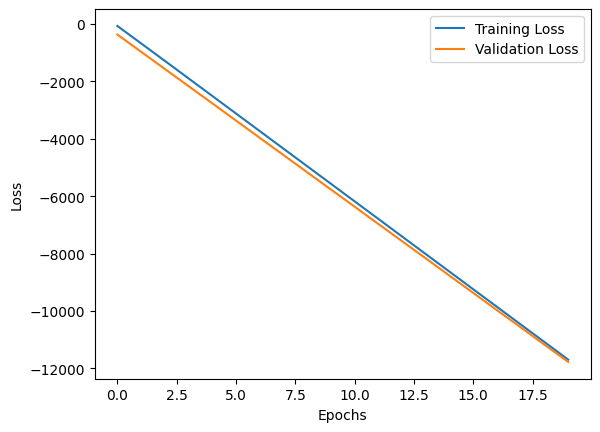

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import tensorflow as tf

# Load the data
X = dataSet_partial['Clue']
y = dataSet_partial['Word']

# Vectorize the text data
vectorizer = TfidfVectorizer()
X_encoded = vectorizer.fit_transform(X).toarray()

character_size = dataSet_partial['Word'].apply(len)

X_processed = pd.DataFrame(X_encoded, columns=vectorizer.get_feature_names_out())
X_processed['Character_Size'] = character_size.values

# Encode the labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_processed, y_encoded, test_size=0.2, random_state=42)

# Convert to numpy arrays
X_train = X_train.to_numpy()
X_test = X_test.to_numpy()

# Build a logistic regression model using Keras
model = tf.keras.Sequential([
    tf.keras.layers.Dense(1, activation='sigmoid', input_shape=(X_train.shape[1],))
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test), verbose=1)

# Plotting the loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


Epoch 1/20
75/75 [==============================] - 1s 6ms/step - loss: 20.1983 - accuracy: 0.0000e+00 - val_loss: 24.0630 - val_accuracy: 0.0017
Epoch 2/20
75/75 [==============================] - 0s 4ms/step - loss: 17.5601 - accuracy: 4.1667e-04 - val_loss: 24.0267 - val_accuracy: 0.0017
Epoch 3/20
75/75 [==============================] - 0s 4ms/step - loss: 22.3221 - accuracy: 0.0000e+00 - val_loss: 23.9907 - val_accuracy: 0.0017
Epoch 4/20
75/75 [==============================] - 0s 4ms/step - loss: 18.6705 - accuracy: 4.1667e-04 - val_loss: 23.9552 - val_accuracy: 0.0017
Epoch 5/20
75/75 [==============================] - 0s 4ms/step - loss: 17.5639 - accuracy: 4.1667e-04 - val_loss: 23.9193 - val_accuracy: 0.0017
Epoch 6/20
75/75 [==============================] - 0s 4ms/step - loss: 21.5299 - accuracy: 4.1667e-04 - val_loss: 23.8831 - val_accuracy: 0.0017
Epoch 7/20
75/75 [==============================] - 0s 4ms/step - loss: 19.9984 - accuracy: 4.1667e-04 - val_loss: 23.8462 -

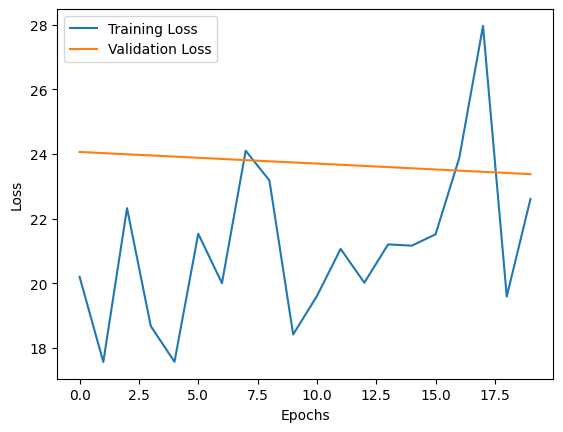

Enter the clue: Studio Fixtures
1/1 [==============================] - 0s 58ms/step
Predicted probability: [[0.49118853]]
The predicted word based on the clue 'Studio Fixtures' is: Negative Class


In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from sklearn.utils.class_weight import compute_class_weight

# Load the data
X = dataSet_partial['Clue']
y = dataSet_partial['Word']

# Vectorize the text data
vectorizer = TfidfVectorizer()
X_encoded = vectorizer.fit_transform(X).toarray()

character_size = dataSet_partial['Word'].apply(len)

X_processed = pd.DataFrame(X_encoded, columns=vectorizer.get_feature_names_out())
X_processed['Character_Size'] = character_size.values

# Convert the target labels to numerical format
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_processed, y_encoded, test_size=0.2, random_state=42)

X_train = X_train.to_numpy()
X_test = X_test.to_numpy()

# Build and compile the model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dropout(0.8),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

optimizer = tf.keras.optimizers.Adam(learning_rate=0.00000001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test), verbose=1)


# Plotting the loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

user_clue = input("Enter the clue: ")

# Vectorize the user input clue
user_clue_encoded = vectorizer.transform([user_clue]).toarray()
user_character_size = len(user_clue)

user_data = np.concatenate((user_clue_encoded, [[user_character_size]]), axis=1)  # Format user data similarly to training data

# Make prediction using the trained model
predicted_prob = model.predict(user_data)

print(f"Predicted probability: {predicted_prob}")

# Apply threshold for binary classification
threshold = 0.5  # Adjust threshold as needed
predicted_binary = 1 if predicted_prob > threshold else 0

if predicted_binary == 1:
    predicted_word = "Positive Class"  # Assign the positive class label
else:
    predicted_word = "Negative Class"  # Assign the negative class label

print(f"The predicted word based on the clue '{user_clue}' is: {predicted_word}")